# Subclass DE

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
#"Astro" : (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d #reds
#"Endo" : (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
#"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
#"Low Quality" : (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
#"SMC" : (0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
#"VLMC" : (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
# (0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
#"Pvalb" : (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
#(0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
#"Pvalb":(0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
}

In [3]:
isoform = anndata.read_h5ad("../cell_ranger_annotation/isoform.h5ad")
gene =    anndata.read_h5ad("../cell_ranger_annotation/gene.h5ad")

In [4]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [5]:
print(isoform.shape)
print(gene.shape)

(6160, 69172)
(6160, 19190)


In [6]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate")
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [7]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
gene_features = gene.var.gene_name.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.90 # of elements in cluster
corr_method = "bonferroni"


p_gene_raw, stat = dexpress(mat, components, gene_features, assignments, 
                      nan_cutoff=nan_cutoff)

p_gene = correct_pval(p_gene_raw, corr_method)
s_gene = stat

02-Mar-20 22:40:52 - 1 of 18 assignments: Astro
02-Mar-20 22:40:53 - 2 of 18 assignments: Endo
02-Mar-20 22:40:53 - 3 of 18 assignments: L2/3 IT
02-Mar-20 22:40:54 - 4 of 18 assignments: L5 ET
02-Mar-20 22:40:55 - 5 of 18 assignments: L5 IT
02-Mar-20 22:40:56 - 6 of 18 assignments: L5/6 NP
02-Mar-20 22:40:57 - 7 of 18 assignments: L6 CT
02-Mar-20 22:40:57 - 8 of 18 assignments: L6 IT
02-Mar-20 22:40:58 - 9 of 18 assignments: L6 IT Car3
02-Mar-20 22:40:59 - 10 of 18 assignments: L6b
02-Mar-20 22:41:00 - 11 of 18 assignments: Lamp5
02-Mar-20 22:41:00 - 12 of 18 assignments: Low Quality
02-Mar-20 22:41:01 - 13 of 18 assignments: Pvalb
02-Mar-20 22:41:02 - 14 of 18 assignments: SMC
02-Mar-20 22:41:02 - 15 of 18 assignments: Sncg
02-Mar-20 22:41:03 - 16 of 18 assignments: Sst
02-Mar-20 22:41:03 - 17 of 18 assignments: VLMC
02-Mar-20 22:41:04 - 18 of 18 assignments: Vip


CPU times: user 7.55 s, sys: 5.54 s, total: 13.1 s
Wall time: 13.1 s


In [8]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.90 # of elements in cluster
corr_method = "bonferroni"


p_isoform_raw, stat = dexpress(mat, components, features, assignments, 
                      nan_cutoff=nan_cutoff)

p_isoform = correct_pval(p_isoform_raw/2, corr_method)
s_isoform = stat

02-Mar-20 22:41:08 - 1 of 18 assignments: Astro
02-Mar-20 22:41:09 - 2 of 18 assignments: Endo
02-Mar-20 22:41:10 - 3 of 18 assignments: L2/3 IT
02-Mar-20 22:41:12 - 4 of 18 assignments: L5 ET
02-Mar-20 22:41:14 - 5 of 18 assignments: L5 IT
02-Mar-20 22:41:16 - 6 of 18 assignments: L5/6 NP
02-Mar-20 22:41:18 - 7 of 18 assignments: L6 CT
02-Mar-20 22:41:20 - 8 of 18 assignments: L6 IT
02-Mar-20 22:41:21 - 9 of 18 assignments: L6 IT Car3
02-Mar-20 22:41:23 - 10 of 18 assignments: L6b
02-Mar-20 22:41:25 - 11 of 18 assignments: Lamp5
02-Mar-20 22:41:27 - 12 of 18 assignments: Low Quality
02-Mar-20 22:41:28 - 13 of 18 assignments: Pvalb
02-Mar-20 22:41:30 - 14 of 18 assignments: SMC
02-Mar-20 22:41:31 - 15 of 18 assignments: Sncg
02-Mar-20 22:41:33 - 16 of 18 assignments: Sst
02-Mar-20 22:41:34 - 17 of 18 assignments: VLMC
02-Mar-20 22:41:35 - 18 of 18 assignments: Vip


CPU times: user 15.4 s, sys: 17.1 s, total: 32.4 s
Wall time: 32.4 s


In [9]:
# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [10]:
repeat_col = gene.var["num_isoforms"]

p1 = p_isoform
p2 = np.repeat(p_gene, repeat_col, axis=1)

s1 = s_isoform
s2 = np.repeat(s_gene, repeat_col, axis=1)

In [11]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

mask = p1_mask
bool_mask = mask

In [12]:
bool_mask.sum()

16162

In [13]:
markers_isoform = pd.DataFrame(index=unique, columns=["transcript_name", "p_raw", "p_bonferroni"])

In [14]:
assignments = gene.obs.subclass_label.values
unique = np.unique(assignments)

In [15]:
isoform_features = isoform.var.transcript_name.values

for uidx, u in enumerate(unique):
    mask = np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_isoform[uidx][mask]
    p_raw = p_isoform_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_isoform.loc[u]["transcript_name"] = fsorted
    markers_isoform.loc[u]["p_raw"] = p_raw_sorted
    markers_isoform.loc[u]["p_bonferroni"] = psorted

In [17]:
[[i.split("_")[0] + "_" + i.split("_")[1]]  for i in markers_isoform.loc['Vip']["transcript_name"]][0:10]

[['Vip-201_ENSMUST00000019906'],
 ['Igsf3-201_ENSMUST00000043983'],
 ['Anapc11-204_ENSMUST00000148114'],
 ['Selenok-201_ENSMUST00000112268'],
 ['Rplp2-201_ENSMUST00000084434'],
 ['Akap9-201_ENSMUST00000044492'],
 ['Sumo2-207_ENSMUST00000153892'],
 ['Rps21-201_ENSMUST00000059080'],
 ['Pfdn2-201_ENSMUST00000006579'],
 ['Snhg9-201_ENSMUST00000161706']]

In [18]:
specific_cluster = "Vip"
specific_isoform = "Vip-201_ENSMUST00000019906"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [19]:
specific_gene

'Vip'

In [20]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['Vip_ENSMUSG00000019772'], dtype=object)

In [21]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

02-Mar-20 22:43:14 - update_title_pos
02-Mar-20 22:43:14 - update_title_pos
02-Mar-20 22:43:14 - update_title_pos
02-Mar-20 22:43:14 - update_title_pos
02-Mar-20 22:43:14 - update_title_pos
02-Mar-20 22:43:14 - update_title_pos
02-Mar-20 22:43:14 - update_title_pos
02-Mar-20 22:43:14 - update_title_pos


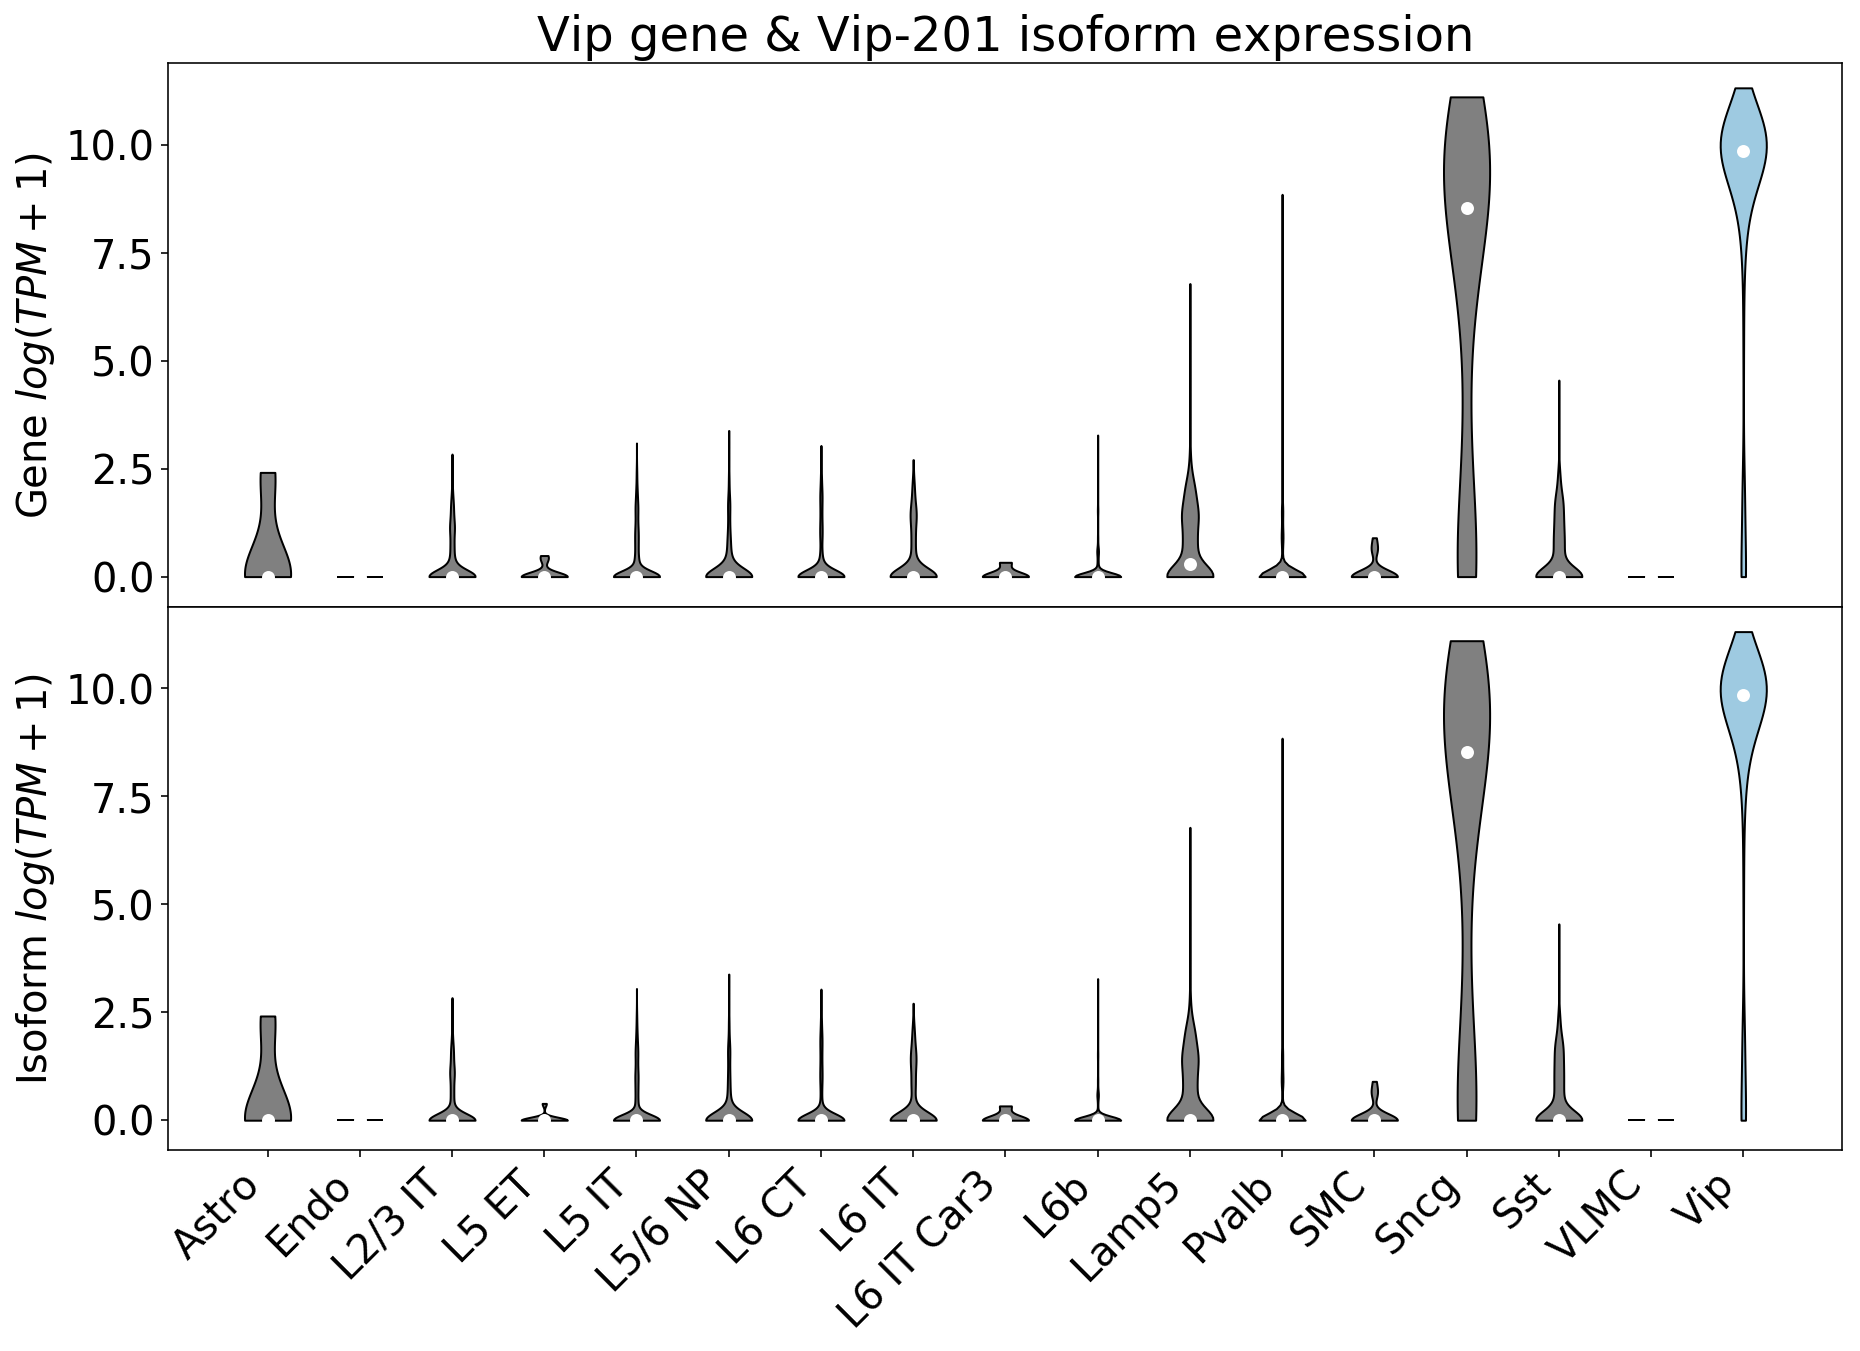

In [23]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor(cluster_cmap[specific_cluster])

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k")
ax[0].set_ylabel("Gene $log(TPM + 1)$")

######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.subclass_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor(cluster_cmap[specific_cluster])

medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylabel("Isoform $log(TPM + 1)$")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
ax[0].set_title("{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]))
#plt.savefig("./figures/subclass_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [24]:
gene

View of AnnData object with n_obs × n_vars = 6160 × 19190 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'

02-Mar-20 22:50:26 - update_title_pos
02-Mar-20 22:50:27 - update_title_pos
02-Mar-20 22:50:27 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos
02-Mar-20 22:50:28 - update_title_pos


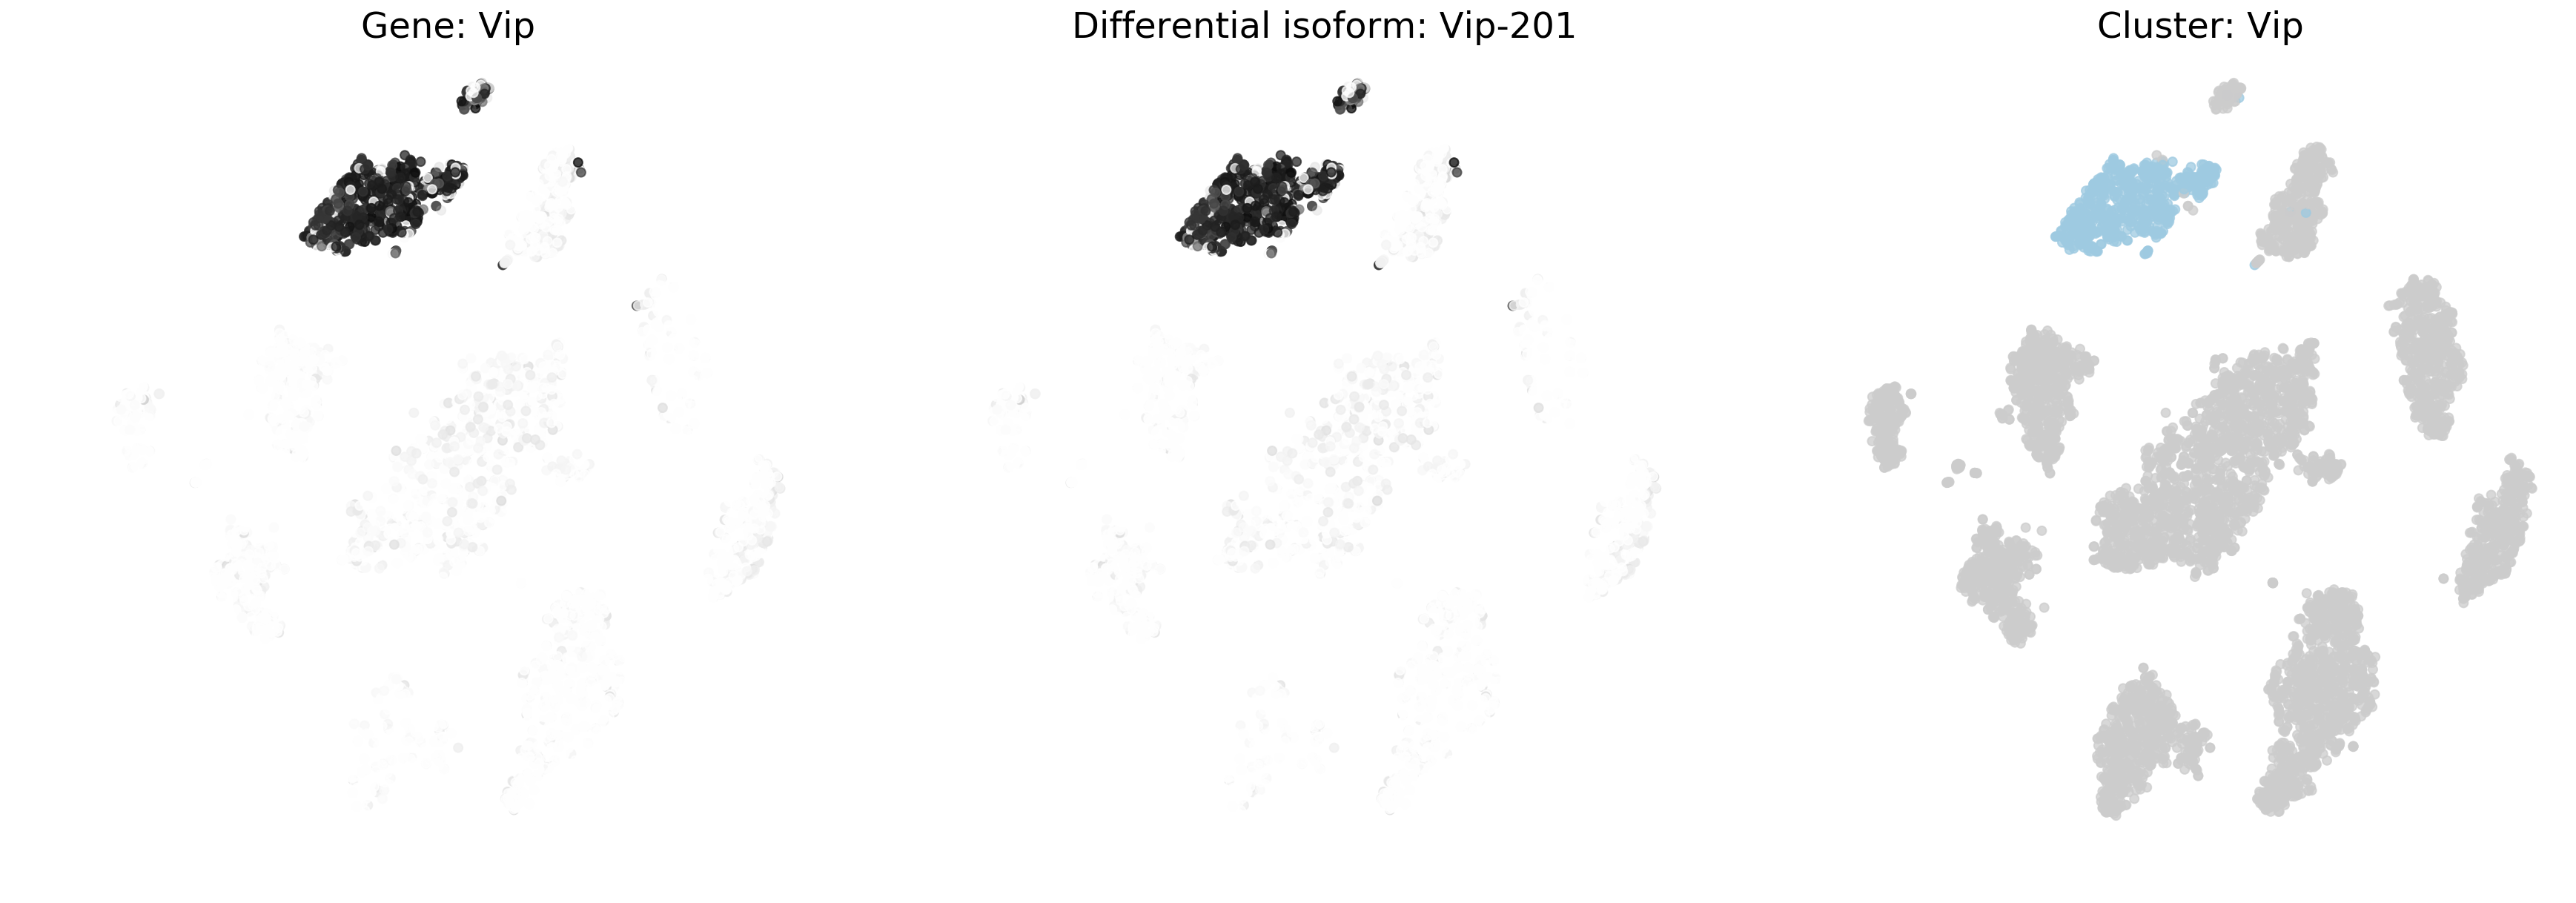

In [31]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(gene.obs["subclass_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster.split("_")[0]))
#plt.savefig("./figures/subclass_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [26]:
identified_isoforms = markers_isoform["transcript_name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [27]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [28]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

2480 isoforms from 2146 genes identified.


In [30]:
markers_isoform.to_csv("tables/subclass_DE_isoform_only.csv")